# Cross-Validation Explained: How K-Fold Stabilises Model Performance Estimates
### Pravinya Rayalapati – Student ID: 24099441

---

## 1. Tutorial Overview

Whenever we train a machine learning model, we need an honest estimate of how well it will perform on new, unseen data. A single train–test split can be misleading: if the split is “lucky”, the model looks great; if it is “unlucky”, the model looks terrible. Cross-validation (CV) is designed to fix this by averaging performance across multiple train–test splits.

In this tutorial I use the **Breast Cancer Wisconsin** dataset and:

- Compare a single train–test split with **K-Fold cross-validation**.
- Show how performance estimates change when we vary **K**.
- Compare cross-validated performance for **Logistic Regression** and **Random Forest**.
- Visualise fold-wise scores and the variability of accuracy estimates.

The goal is to make cross-validation concrete, visual and intuitive, not just a function call in scikit-learn.


## 2. Intuition and Real-Life Analogy

Imagine you want to judge a student’s maths ability. If you give them **one exam only**, your judgement depends heavily on that single paper. Maybe the exam was unusually easy, or maybe it focused on the one topic they hate. Your estimate of their ability is very noisy.

A better strategy is to give several different exams, each covering slightly different questions, and then take the **average mark**. Now your judgement is much more stable. This is essentially what **K-Fold cross-validation** does for machine learning models: instead of scoring the model once, it :

1. Splits the dataset into **K folds**.
2. Trains on K–1 folds and tests on the remaining fold.
3. Repeats this so that each fold becomes the test set once.
4. Averages the K scores into a more reliable performance estimate.

In the rest of the notebook I turn this idea into code and plots.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
np.random.seed(42)


## 3. Dataset: Breast Cancer Wisconsin

The Breast Cancer Wisconsin dataset contains 569 examples of breast tissue measurements, each described by 30 numeric features (texture, radius, smoothness, etc.) and a binary label:

- `0` – malignant tumour  
- `1` – benign tumour  

I use this dataset because:

- it is widely used in the literature,
- the task is clinically meaningful (cancer diagnosis),
- and it is large enough to illustrate the variability of performance estimates.


In [2]:
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

X.shape, np.bincount(y)


((569, 30), array([212, 357]))

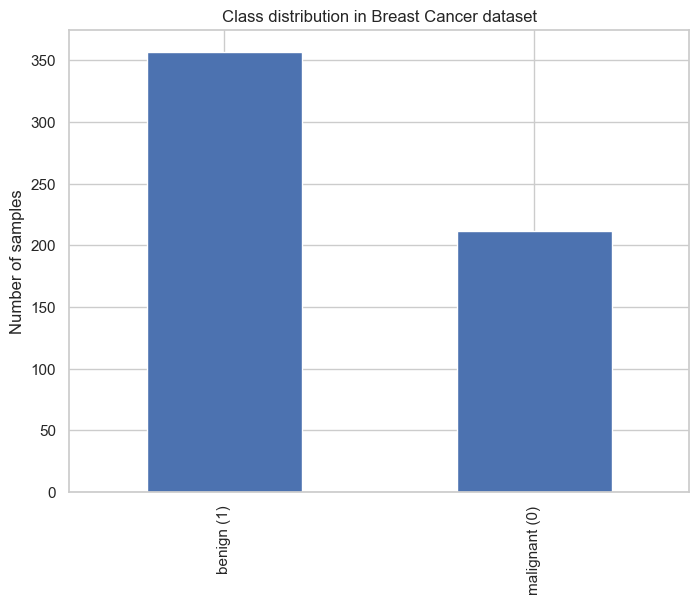

In [ ]:
class_counts = pd.Series(y).value_counts()
class_counts.index = ["benign (1)", "malignant (0)"]
class_counts.plot(kind="bar")
plt.title("Class distribution in Breast Cancer dataset")
plt.ylabel("Number of samples")
plt.show() 


## 4. Baseline: Single Train–Test Split

I start with the usual approach: split the data once into **training** and **test** sets, fit a logistic regression model, and measure accuracy.

To handle the different numerical scales of the breast cancer features, I place **StandardScaler + LogisticRegression** inside a `Pipeline`.

The key question is: **how stable is this single accuracy number?**


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))
])

log_reg_pipeline.fit(X_train, y_train)
y_pred = log_reg_pipeline.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)
baseline_acc


0.9824561403508771

### 4.1 Sensitivity to the Random Split

To show how unstable a single split can be, I repeat the train–test split with different `random_state` values and record the accuracy each time. This simulates “different exam papers” for the model.


In [5]:
def single_split_accuracy(random_state):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))
    ])
    model.fit(X_train, y_train)
    return accuracy_score(y_test, model.predict(X_test))

random_states = range(10, 60, 5)
single_split_scores = [single_split_accuracy(rs) for rs in random_states]

pd.DataFrame({"random_state": random_states, "accuracy": single_split_scores})


,random_state,accuracy
0,10,0.964912
1,15,0.991228
2,20,0.982456
3,25,0.982456
4,30,0.982456
5,35,0.973684
6,40,1.000000
7,45,0.964912
8,50,0.982456
9,55,0.956140


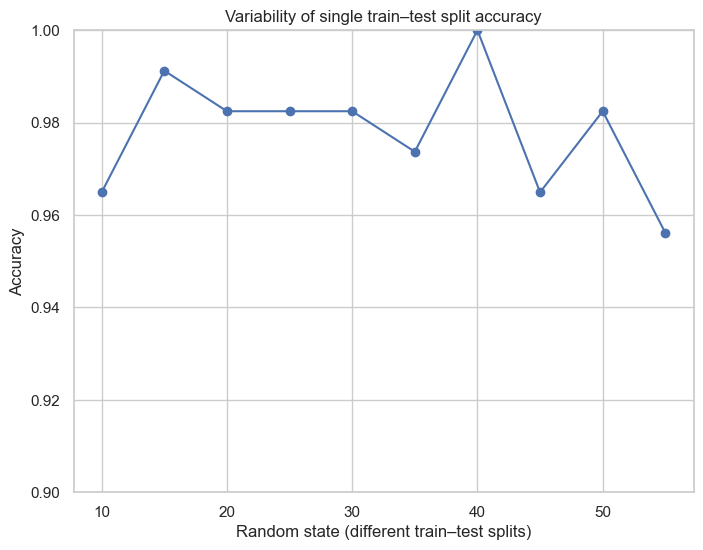

In [ ]:
plt.plot(random_states, single_split_scores, marker="o")
plt.xlabel("Random state (different train–test splits)")
plt.ylabel("Accuracy")
plt.title("Variability of single train–test split accuracy")
plt.ylim(0.9, 1.0)
plt.show() 


## 5. K-Fold Cross-Validation

Now I apply **K-Fold cross-validation**:

1. Split the data into K folds.
2. For each fold:
   - train on K–1 folds,
   - test on the remaining fold.
3. Collect K accuracy scores and compute their **mean** and **standard deviation**.

This produces a more reliable estimate than a single split, because every sample is used for both training and testing (in different folds), and the model is evaluated on multiple, diverse splits.


In [7]:
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))
])

cv_scores = cross_val_score(log_reg_pipeline, X, y, cv=cv, scoring="accuracy")
cv_scores, cv_scores.mean(), cv_scores.std()


(array([0.97368421, 0.98245614, 0.96491228, 0.99122807, 0.97345133]),
 0.9771464058376029,
 0.008964382519164905)

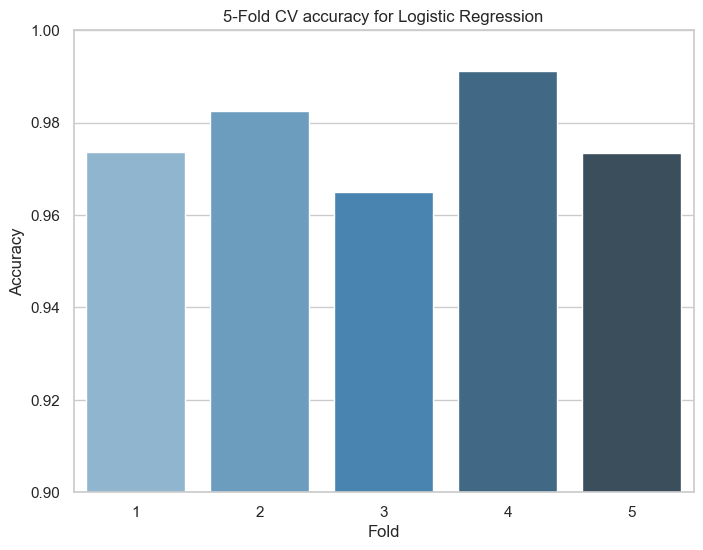

In [ ]:
fold_indices = np.arange(1, k+1)
sns.barplot(x=fold_indices, y=cv_scores, palette="Blues_d")
plt.ylim(0.9, 1.0)
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("5-Fold CV accuracy for Logistic Regression")
plt.show() 


### 5.1 Single Split vs 5-Fold CV

- **Single split baseline accuracy**: stored in `baseline_acc`.
- **5-Fold CV mean accuracy**: `cv_scores.mean()`.
- **5-Fold CV standard deviation**: `cv_scores.std()`.

The single split gives one number; cross-validation gives a **distribution of scores**, from which we can measure both the central tendency (mean) and the reliability (standard deviation).


In [9]:
summary = pd.DataFrame({
    "method": ["single split", "5-fold CV"],
    "mean_accuracy": [baseline_acc, cv_scores.mean()],
    "std_accuracy": [np.nan, cv_scores.std()]
})
summary


,method,mean_accuracy,std_accuracy
0,single split,0.982456,NaN
1,5-fold CV,0.977146,0.008964


## 6. Effect of Different K Values

Next, I vary **K** (3, 5, 10) and measure:

- mean accuracy
- standard deviation of accuracy across folds

The trade-off:

- Smaller K (e.g. 3): fewer models to train, but higher variance in the estimate.
- Larger K (e.g. 10): more stable estimate, but more computation.


In [11]:
k_values = [3, 5, 10]
results = []

for k in k_values:
    cv = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(log_reg_pipeline, X, y, cv=cv, scoring="accuracy")
    results.append({
        "K": k,
        "mean_accuracy": scores.mean(),
        "std_accuracy": scores.std()
    })

cv_k_df = pd.DataFrame(results)
cv_k_df


,K,mean_accuracy,std_accuracy
0,3,0.973619,0.007535
1,5,0.977146,0.008964
2,10,0.975407,0.019525


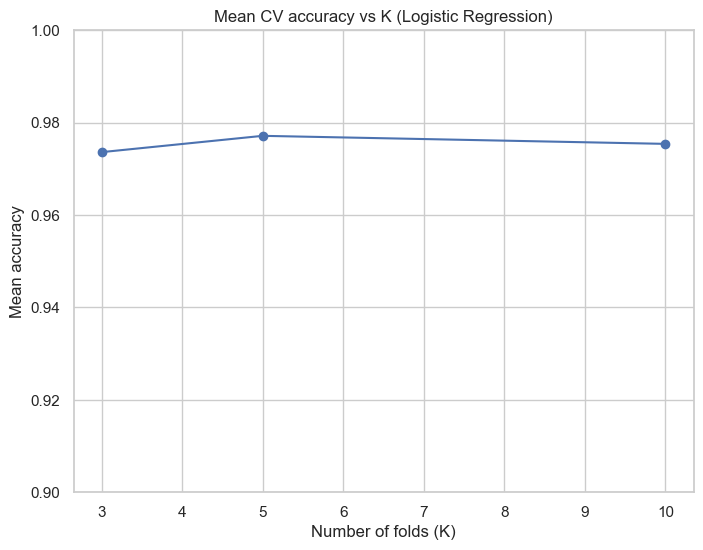

In [12]:
plt.plot(cv_k_df["K"], cv_k_df["mean_accuracy"], marker="o")
plt.xlabel("Number of folds (K)")
plt.ylabel("Mean accuracy")
plt.ylim(0.9, 1.0)
plt.title("Mean CV accuracy vs K (Logistic Regression)")
plt.show()  # <<FIGURE 4 PLACEHOLDER>>


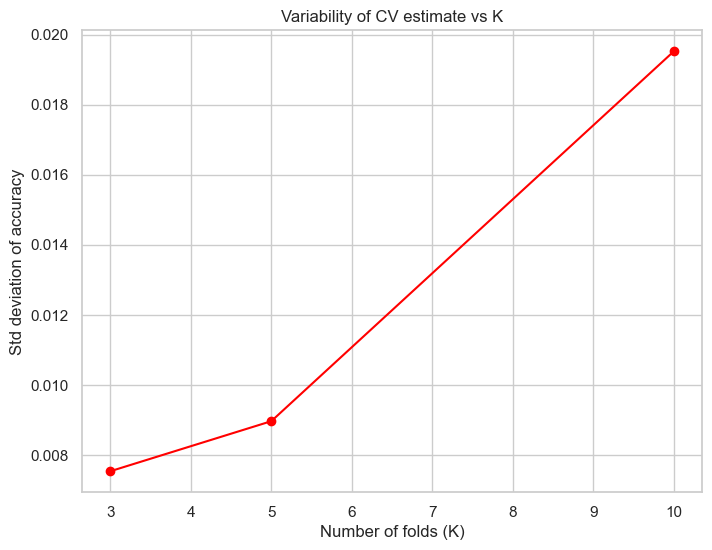

In [13]:
plt.plot(cv_k_df["K"], cv_k_df["std_accuracy"], marker="o", color="red")
plt.xlabel("Number of folds (K)")
plt.ylabel("Std deviation of accuracy")
plt.title("Variability of CV estimate vs K")
plt.show()


## 7. Comparing Models with Cross-Validation

Cross-validation is not just for a single model; it is also the fairest way to compare different models on the same dataset.

Here I compare:

- **Model 1**: Logistic Regression (`log_reg_pipeline`)
- **Model 2**: Random Forest (`rf_clf`)

I use 5-fold CV and compare their mean and standard deviation of accuracy.


In [14]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)

k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

log_scores = cross_val_score(log_reg_pipeline, X, y, cv=cv, scoring="accuracy")
rf_scores = cross_val_score(rf_clf, X, y, cv=cv, scoring="accuracy")

model_compare_df = pd.DataFrame({
    "model": ["Logistic Regression"]*k + ["Random Forest"]*k,
    "fold": list(range(1, k+1))*2,
    "accuracy": np.concatenate([log_scores, rf_scores])
})
model_compare_df


,model,fold,accuracy
0,Logistic Regression,1,0.973684
1,Logistic Regression,2,0.982456
2,Logistic Regression,3,0.964912
3,Logistic Regression,4,0.991228
4,Logistic Regression,5,0.973451
5,Random Forest,1,0.964912
6,Random Forest,2,0.973684
7,Random Forest,3,0.947368
8,Random Forest,4,0.964912
9,Random Forest,5,0.964602


/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


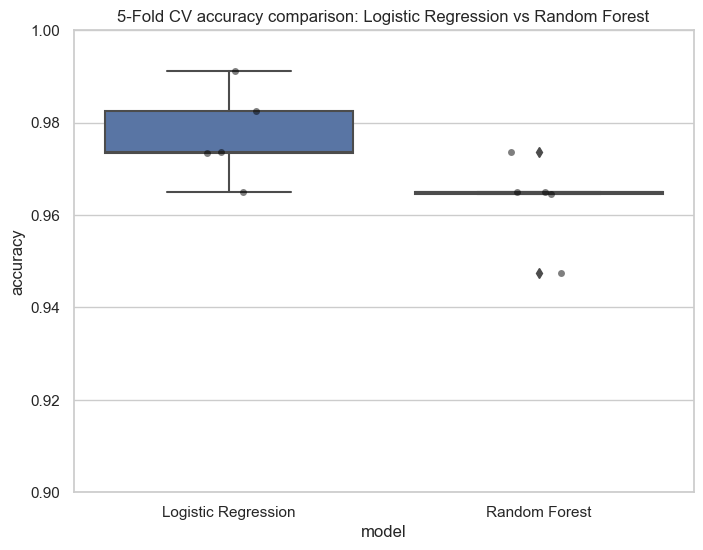

In [ ]:
sns.boxplot(x="model", y="accuracy", data=model_compare_df)
sns.stripplot(x="model", y="accuracy", data=model_compare_df, color="black", alpha=0.5)
plt.ylim(0.9, 1.0)
plt.title("5-Fold CV accuracy comparison: Logistic Regression vs Random Forest")
plt.show()


In [16]:
model_summary = model_compare_df.groupby("model")["accuracy"].agg(
    mean_accuracy="mean", std_accuracy="std"
)
model_summary


,mean_accuracy,std_accuracy
model,,
Logistic Regression,0.977146,0.010022
Random Forest,0.963096,0.009596


## 8. Summary of Findings

In this notebook I:

- Showed that **single train–test splits** produce accuracy estimates that vary with the random state.
- Used **K-Fold cross-validation** on the Breast Cancer dataset to obtain a more stable estimate of the performance of Logistic Regression.
- Demonstrated how changing **K** affects both the mean accuracy and its variability.
- Compared **Logistic Regression** and **Random Forest** using 5-fold CV, showing how cross-validation provides a fair, apples-to-apples comparison.

In the written report I will interpret each figure in detail, connect the results to the bias–variance trade-off, and relate the findings to the broader literature on model evaluation.

All figures referenced there correspond to the placeholders indicated in the comments above.
